## seq2seq
本例使用tensorflow的seq2seq实现输入一组单词输出其排序后的结果

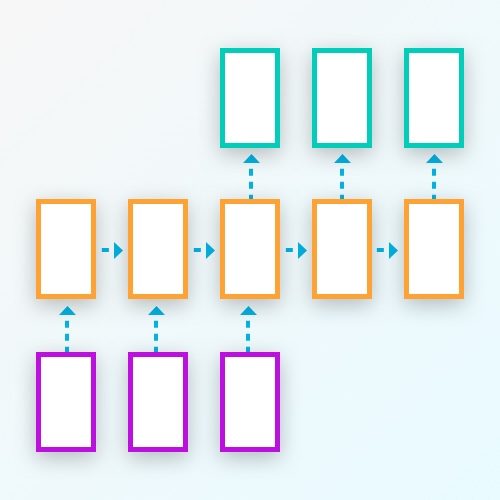

### 获取数据

In [1]:
import helper

source_path = 'data/letters_source.txt'
target_path = 'data/letters_target.txt'

source_sentences = helper.load_data(source_path)
target_sentences = helper.load_data(target_path)

In [2]:
source_sentences[:50].split('\n')#源数据

['bsaqq',
 'npy',
 'lbwuj',
 'bqv',
 'kial',
 'tddam',
 'edxpjpg',
 'nspv',
 'huloz',
 '']

In [3]:
target_sentences[:50].split('\n')#target,可以看出是排序后的结果

['abqqs',
 'npy',
 'bjluw',
 'bqv',
 'aikl',
 'addmt',
 'degjppx',
 'npsv',
 'hlouz',
 '']

### 预处理
为了是输入的长度一致，使用pad,unk等来对一些特殊情况进行填充，所以他们也需要和字母一起统一编码转换成数字。

PAD主要用来进行字符补全，

EOS和GO都是用在Decoder端的序列中，告诉解码器句子的起始与结束，

UNK则用来替代一些未出现过的词或者低频词。

In [7]:
def extract_character_vocab(data):
    special_words = ['<pad>', '<unk>', '<s>',  '<\s>']
    
    #第一步：去重
    character_set = set([character for word in data.split('\n') for character in list(word)])
    #第二步：int_to_vocab & vocab_to_int
    int_to_vocab = {cc:word for cc,word in enumerate(list(character_set)+special_words)}
    vocab_to_int = {word:cc for cc,word in int_to_vocab.items()}                                                
    
    return int_to_vocab,vocab_to_int

source_int_to_letter,source_letter_to_int = extract_character_vocab(source_sentences)
target_int_to_letter,target_letter_to_int = extract_character_vocab(target_sentences)

#将源数据集和目标数据集都转换成数字id，根据上面的转换结果
#这里字典的get方法是如果查找失败则返回默认值get(key,default)
source_letter_ids = [[source_letter_to_int.get(letter, source_letter_to_int['<unk>']) for letter in line] for line in source_sentences.split('\n')]
target_letter_ids = [[target_letter_to_int.get(letter,target_letter_to_int['<unk>']) for letter in word] for word in target_sentences.split('\n')]



In [8]:
print("Example source sequence")
print(source_letter_ids[:3])
print("\n")
print("Example target sequence")
print(target_letter_ids[:3])

Example source sequence
[[16, 3, 20, 15, 15], [7, 11, 5], [21, 16, 23, 8, 10]]


Example target sequence
[[20, 15, 16, 16, 3], [7, 11, 5], [15, 10, 21, 8, 23]]


接下来就是确定所有序列中最长的，然后将其他序列都扩展成一样长。

In [14]:
#获取最长的序列长度
seq_len = max([len(source) for source in source_letter_ids] + [len(target) for target in target_letter_ids])
print("max seq len is ",seq_len)

#扩展序列
"""
这里是将原来一行ids通过扩展seq_len-len(word)个长度的<pad>来实现的，
注意因为只有list可以扩展，所以要[]*(扩展长度)
source_letter_to_int['<pad>']是int，所以需要再加一个[]将其转换成list才能乘以后面的长度！！！
"""
def pad_id_sequences(source_ids, source_letter_to_int, target_ids, target_letter_to_int, sequence_length):
    new_source_ids = [word + [source_letter_to_int['<pad>']]*(seq_len-len(word)) for word in source_ids]
    new_target_ids = [word + [target_letter_to_int['<pad>']]*(seq_len - len(word)) for word in target_ids]
    return new_source_ids,new_target_ids

source_ids, target_ids = pad_id_sequences(source_letter_ids, source_letter_to_int, 
                                          target_letter_ids, target_letter_to_int, seq_len)
    

max seq len is  7


In [16]:
print("Sequence Length")
print(seq_len)
print("\n")
print("Input sequence example")
print(source_ids[:3])
print("\n")
print("Target sequence example")
print(target_ids[:3])
#可以看出<pad>对应是id是26，所有长度不及7的，后面都填充26进行扩充

Sequence Length
7


Input sequence example
[[16, 3, 20, 15, 15, 26, 26], [7, 11, 5, 26, 26, 26, 26], [21, 16, 23, 8, 10, 26, 26]]


Target sequence example
[[20, 15, 16, 16, 3, 26, 26], [7, 11, 5, 26, 26, 26, 26], [15, 10, 21, 8, 23, 26, 26]]


### 模型

In [17]:
from distutils.version import LooseVersion
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer'
print('TensorFlow Version: {}'.format(tf.__version__))

TensorFlow Version: 1.2.1


### 设置超参数

In [18]:
# Number of Epochs
epochs = 60
# Batch Size
batch_size = 128
# RNN Size
rnn_size = 50
# Number of Layers
num_layers = 2
# Embedding Size
encoding_embedding_size = 13
decoding_embedding_size = 13
# Learning Rate
learning_rate = 0.001

## 神经网络定义
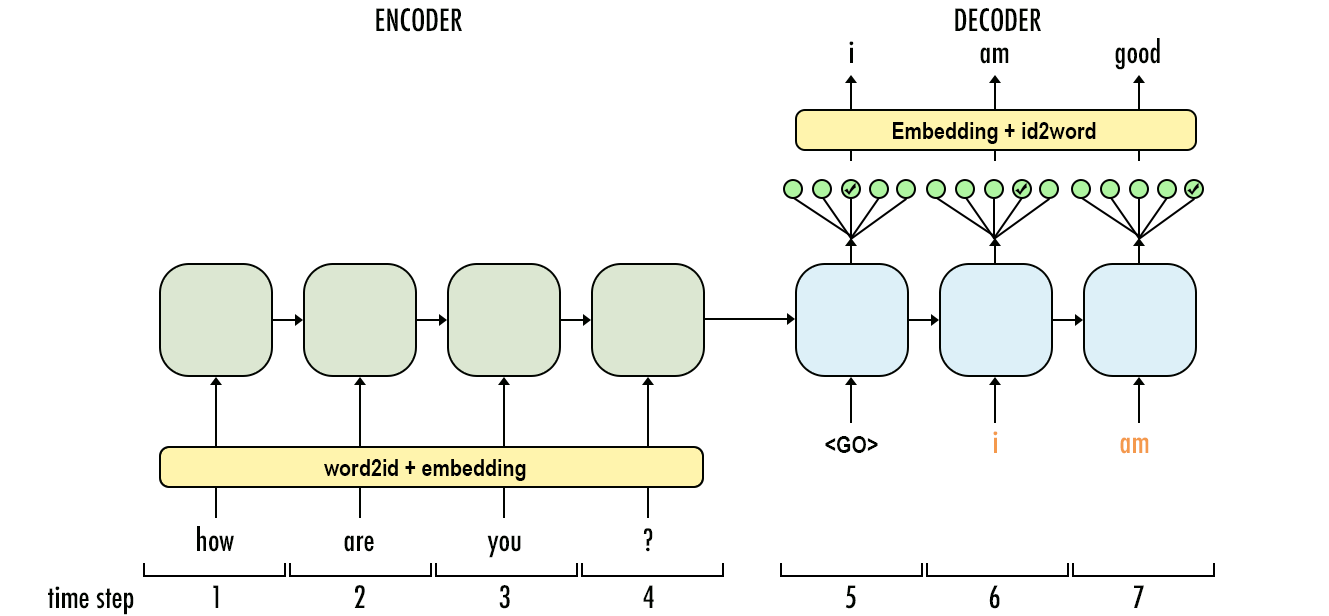

### 输入

In [19]:
inputs = tf.placeholder(tf.int32,[batch_size,seq_len])#应该是batch_size*单个输入的长度
labels = tf.placeholder(tf.int32,[batch_size,seq_len])#输出因为是输入的排序，所以是一样的尺寸
lr = tf.placeholder(tf.float32)

### Encoding

In [ ]:
#首先从input->embed,然后rnn
#embed使用 tf.contrib.layers.embed_sequence
